In [1]:
#% reset
import tensorflow as tf
import numpy as np
from tensorflow.python.ops import math_ops
import matplotlib.pyplot as plt
import time
import os
import midi_musical_matrix
import data
import multi_training
from tensorflow.contrib.rnn import BasicLSTMCell
from tensorflow.contrib.rnn import LSTMStateTuple
from MyFunctions import Input_Kernel, LSTM_TimeWise_Training_Layer, LSTM_NoteWise_Layer, Loss_Function

# Plot configurations
% matplotlib inline
# Notebook auto reloads code. (Ref: http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython)
% load_ext autoreload
% autoreload 2


In [2]:
# Import All Training Data
# Convert Entire Music .MIDI set to list of musical 'pieces'
# During training runs, getPieceBatch will return a tensor for Note_State_Batch, and corresponding Note_State_Expand
# Note_State_Expand will be fed into the graph input, and Note_State_Batch will be used for the loss function.

# Import Midi files to list
Working_Directory = os.getcwd()
Training_Midi_Folder = Working_Directory + "/Midi_Files/Bach"
max_time_steps = 256 # only files atleast this many 16th note steps are saved

practice_batch_size = 15
practice_num_timesteps = 128


training_pieces = multi_training.loadPieces(Training_Midi_Folder, max_time_steps)
print('')
print('Number of training pieces = ', len(training_pieces))

# Generate sample Note State Matrix for dimension measurement and numerical checking purposes
# (Using external code to generate the Note State Matrix but using our own NoteInputForm (as defined in author's code) function
_, sample_state = multi_training.getPieceBatch(training_pieces, practice_batch_size, practice_num_timesteps)
sample_state = np.array(sample_state)
sample_state = np.swapaxes(sample_state, axis1=1, axis2=2)
print('Sample of State Input Batch: shape = ', sample_state.shape)


Skip bad file =  Fugue12
Loaded schub5
Loaded tri2
Loaded sinfon1 (1)
Loaded 01Prelude
Loaded Prelude12
Loaded BRAND3
Loaded Fugue8
Loaded Fugue22
Loaded Prelude21
Loaded 04Bourree
Loaded BSGJG_H
Loaded Fugue18
Loaded 11Jesu
Loaded Fugue5
Loaded sinfon4
Skip bad file =  Fugue19
Loaded Fugue4
Loaded unfin
Loaded can4
Loaded Fugue17
Loaded 04Prelude
Loaded sinfon12
Skip bad file =  Prelude20
Loaded dou2
Loaded prefug5
Loaded prefug3
Loaded gig1
Loaded catech6
Loaded prefug7
Loaded BRAND43
Loaded 08Freueteuch
Loaded dou1
Loaded Fugue9 (1)
Loaded Fugue7 (1)
Loaded toccata1
Loaded sinfon1
Loaded BRAND51
Loaded invent13
Loaded sinfon14
Loaded 01Allemande
Loaded Fugue3
Skip bad file =  Prelude13
Loaded Prelude5
Loaded cnt1
Loaded sinfon3
Loaded cnt3
Loaded 09Ermuntredich
Loaded invent7
Loaded Prelude8 (1)
Loaded invent5
Loaded cap2
Loaded 15ChristlaginTode
Loaded BRAND53
Loaded sin2
Loaded Prelude3 (1)
Loaded Prelude2 (1)
Loaded invent14
Loaded 10AustieferNot
Loaded inver2
Loaded 13Alleinzudi

In [29]:
# Beginning of Model Graph:
tf.reset_default_graph()

#input_size = sample_state.shape[-1]
num_notes = sample_state.shape[1]


#place holder inputs
# num_batches and num_time steps are variable lengths.  These values do not affect the model parameters
# Dimension(0) =  num_batches. Dimension(2) = num_time_steps

#final_t_sample_run = np.zeros((batch_size, num_notes, 1, 2)) #start every batch with zero previous input


        
Note_State_Batch = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 2])
#prev_t_sample = tf.placeholder(dtype=tf.float32, shape=[None, num_notes,1,2])
time_init = tf.placeholder(dtype=tf.int32, shape=())
#Generates expanded tensor input to LSTM-timewise layer
Note_State_Expand = Input_Kernel(Note_State_Batch, Midi_low=24, Midi_high=101, time_init=time_init)

print('Note_State_Batch Placeholder Shape = ', Note_State_Batch.get_shape())
print('Note_State_Expand output Shape = ', Note_State_Expand.get_shape())





Note_State_Batch Placeholder Shape =  (?, 78, ?, 2)
Note_State_Expand output Shape =  (?, 78, ?, 80)


In [30]:
# Check Input Kernel on sample data

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sample_expand = sess.run(Note_State_Expand, feed_dict={Note_State_Batch: sample_state, time_init: 1})



#check MIDI note
print('sample_expand shape = ', sample_expand.shape)
print('MIDI note_0, t_0 = ', sample_expand[0,0,0,[0]]) 
print('MIDI note_1, t_0 = ', sample_expand[0,1,0,[0]])  
print('MIDI note_2, t_0 = ', sample_expand[0,2,0,[0]]) 

print('MIDI note_0, t_0 = ', sample_expand[0,0,0,[0]]) 
print('MIDI note_0, t_1 = ', sample_expand[0,0,1,[0]])  
print('MIDI note_0, t_29 = ', sample_expand[0,0,29,[0]]) 
print('') 

#check pitchclass
print('pitchclass note_0, t_0 = ', sample_expand[0,0,0,1:13]) 
print('pitchclass note_1, t_0 = ', sample_expand[0,1,0,1:13])  
print('pitchclass note_11, t_0 = ', sample_expand[0,11,0,1:13]) 

print('pitchclass note_0, t_0 = ', sample_expand[0,0,0,1:13]) 
print('pitchclass note_0, t_1 = ', sample_expand[0,0,1,1:13])  
print('pitchclass note_0, t_29 = ', sample_expand[0,0,29,1:13]) 
print('') 

#check vicinity
print('sample state local vicinity = ', sample_state[0,33:58,29,:])
print('calculated vicinity note_45, t_29 = ', sample_expand[0,45,29,13:63])
print('')

#check  context
print('calculated context note_45, t_29 = ', sample_expand[0,45,29,63:75])
print('actual all note plays at, t_29 = ', sample_state[0,:,29,0])
print('')

#check beat
print('beat note_0, t_0 = ', sample_expand[0,0,0,75:79]) 
print('beat note_1, t_0 = ', sample_expand[0,1,0,75:79])  
print('beat note_2, t_0 = ', sample_expand[0,2,0,75:79]) 

print('beat note_0, t_0 = ', sample_expand[0,0,0,75:79]) 
print('beat note_0, t_1 = ', sample_expand[0,0,1,75:79])  
print('beat note_0, t_29 = ', sample_expand[0,0,29,75:79]) 
print('')


sample_expand shape =  (15, 78, 128, 80)
MIDI note_0, t_0 =  [ 24.]
MIDI note_1, t_0 =  [ 25.]
MIDI note_2, t_0 =  [ 26.]
MIDI note_0, t_0 =  [ 24.]
MIDI note_0, t_1 =  [ 24.]
MIDI note_0, t_29 =  [ 24.]

pitchclass note_0, t_0 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_1, t_0 =  [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_11, t_0 =  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
pitchclass note_0, t_0 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_0, t_1 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
pitchclass note_0, t_29 =  [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]

sample state local vicinity =  [[0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [1 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]
 [0 0]]
calculated vicinity note_45, t_29 =  [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0

In [31]:
#lSTM Time Wise Training Graph 
#tf.reset_default_graph()
#Note_State_Expand = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 80])
#Note_State_Expand_val = np.ones((10,78,128,80))

num_t_units=[300,200]
output_keep_prob = tf.placeholder(dtype=tf.float32, shape=())

# Generate initial state (at t=0) placeholder
timewise_state=[]
for i in range(len(num_t_units)):
    timewise_c=tf.placeholder(dtype=tf.float32, shape=[None, num_t_units[i]]) #None = batch_size * num_notes
    timewise_h=tf.placeholder(dtype=tf.float32, shape=[None, num_t_units[i]])
    timewise_state.append(LSTMStateTuple(timewise_h, timewise_c))

timewise_state=tuple(timewise_state)


timewise_out, timewise_state_out = LSTM_TimeWise_Training_Layer(input_data=Note_State_Expand, state_init=timewise_state, output_keep_prob=output_keep_prob)


print('Time-wise output shape = ', timewise_out.get_shape())
print(len(timewise_state_out))



Time-wise output shape =  (?, 78, ?, 200)
2


In [32]:
#LSTM Note Wise Graph
#tf.reset_default_graph()
#timewise_out = tf.placeholder(dtype=tf.float32, shape=[None, num_notes, None, 50])

num_n_units = [100,50]

# Generate initial state (at n=0) placeholder
notewise_state=[]
for i in range(len(num_n_units)):
    notewise_c=tf.placeholder(dtype=tf.float32, shape=[None, num_n_units[i]]) #None = batch_size * num_timesteps
    notewise_h=tf.placeholder(dtype=tf.float32, shape=[None, num_n_units[i]])
    notewise_state.append(LSTMStateTuple(notewise_h, notewise_c))

notewise_state=tuple(notewise_state)


y_out, note_gen_out = LSTM_NoteWise_Layer(timewise_out, state_init=notewise_state, output_keep_prob=output_keep_prob)


print('y_out shape = ', y_out.get_shape())
print('generated samples shape = ', note_gen_out.get_shape())




y_out shape =  (?, 78, ?, 2, 2)
generated samples shape =  (?, 78, ?, 2)


In [33]:
# Loss Function and Optimizer

#y_out_val = np.random.randn(1, 78, 128, 2, 2)*5


loss, cross_entropy = Loss_Function(Note_State_Batch, y_out)
optimizer = tf.train.AdadeltaOptimizer(learning_rate = 1).minimize(loss)



#with tf.Session() as sess:
#    sess.run(tf.global_variables_initializer())
#    cross_entropy_out, loss_out = sess.run([cross_entropy, loss], feed_dict={y_out: y_out_val, Note_State_Batch: batch_input_state})
#print('cross entropy shape = ', cross_entropy_out.shape)
#print('loss = ', loss_out)

y_align shape = :  (?, ?, ?, ?, ?)
Note_State_Batch_align shape = :  (?, ?, ?, ?)


In [34]:
# Training
N_epochs = 2000
loss_hist=[]
restore_model_name = None
save_model_name = 'Practice_Dropout'
batch_size = 10
num_timesteps = 128
keep_prob=.5

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    # try to restore the pre_trained
    if restore_model_name is not None:
        print("Load the model from: {}".format(restore_model_name))
        saver.restore(sess, 'model/{}'.format(restore_model_name))
    
    # Initial States
    timewise_state_val=[]
    for i in range(len(num_t_units)):
        c_t = np.zeros((batch_size*num_notes, num_t_units[i])) #start every batch with zero state in LSTM time cells
        h_t = np.zeros((batch_size*num_notes, num_t_units[i]))
        timewise_state_val.append(LSTMStateTuple(h_t, c_t))
        
    notewise_state_val=[]
    for i in range(len(num_n_units)):
        c_n = np.zeros((batch_size*num_timesteps, num_n_units[i])) #start every batch with zero state in LSTM time cells
        h_n = np.zeros((batch_size*num_timesteps, num_n_units[i]))
        notewise_state_val.append(LSTMStateTuple(h_n, c_n))
    
  

    # Training Loop
    for epoch in range(N_epochs):
        
        #Generate random batch of training data
        
        if epoch % 100 == 0:
            print('Obtaining new batch of pieces')
            _, batch_input_state = multi_training.getPieceBatch(training_pieces, batch_size, num_timesteps) # not using their 'convolution' filter
            batch_input_state = np.array(batch_input_state)
            batch_input_state = np.swapaxes(batch_input_state, axis1=1, axis2=2)           
     
        
        """
        print('Note_State_Batch shape = ', Note_State_Batch.get_shape())
        print('batch_input_state shape = ', batch_input_state.shape)
        print('')
        print('timewise_state shape = ', Note_State_Batch.get_shape())
        print('timewise_state_val shape = ', batch_input_state.shape)      
        print('')
        print('notewise_state shape = ', Note_State_Batch.get_shape())
        print('notewise_state_val shape = ', batch_input_state.shape)
        ('')
        print('time_init shape = ', time_init.get_shape())
        """
    
        feed_dict = {Note_State_Batch: batch_input_state, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: 0, output_keep_prob: keep_prob}
        #try:
        loss_run, _ = sess.run([loss, optimizer], feed_dict=feed_dict)
        #except:
        #   save_path = saver.save(sess, 'model/{}'.format(save_model_name))
        #    print("Model saved in file: %s" % save_path)
        
        print('epoch = ', epoch, '; loss = ', loss_run)
        loss_hist.append(loss_run)
        
        if epoch % 100 == 0:
            save_path = saver.save(sess, 'model/{}'.format(save_model_name))
            print("Model saved in file: %s" % save_path)
            
    save_path = saver.save(sess, 'model/{}'.format(save_model_name))
    print(" Final Model saved in file: %s" % save_path)


Obtaining new batch of pieces
epoch =  0 ; loss =  0.698937
Model saved in file: model/Practice_Dropout
epoch =  1 ; loss =  0.671152
epoch =  2 ; loss =  0.656158
epoch =  3 ; loss =  0.64548
epoch =  4 ; loss =  0.635729
epoch =  5 ; loss =  0.62747
epoch =  6 ; loss =  0.617929
epoch =  7 ; loss =  0.608594
epoch =  8 ; loss =  0.600378
epoch =  9 ; loss =  0.592904
epoch =  10 ; loss =  0.585964
epoch =  11 ; loss =  0.579343
epoch =  12 ; loss =  0.573893
epoch =  13 ; loss =  0.566723
epoch =  14 ; loss =  0.557982
epoch =  15 ; loss =  0.54883
epoch =  16 ; loss =  0.53913
epoch =  17 ; loss =  0.531932
epoch =  18 ; loss =  0.523768
epoch =  19 ; loss =  0.517374
epoch =  20 ; loss =  0.511961
epoch =  21 ; loss =  0.507406
epoch =  22 ; loss =  0.502359
epoch =  23 ; loss =  0.495964
epoch =  24 ; loss =  0.484505
epoch =  25 ; loss =  0.474616
epoch =  26 ; loss =  0.463629
epoch =  27 ; loss =  0.454367
epoch =  28 ; loss =  0.446123
epoch =  29 ; loss =  0.437807
epoch =  3

epoch =  254 ; loss =  0.13343
epoch =  255 ; loss =  0.134758
epoch =  256 ; loss =  0.133282
epoch =  257 ; loss =  0.133847
epoch =  258 ; loss =  0.133672
epoch =  259 ; loss =  0.132541
epoch =  260 ; loss =  0.132815
epoch =  261 ; loss =  0.133178
epoch =  262 ; loss =  0.133773
epoch =  263 ; loss =  0.133146
epoch =  264 ; loss =  0.132923
epoch =  265 ; loss =  0.13197
epoch =  266 ; loss =  0.131726
epoch =  267 ; loss =  0.13154
epoch =  268 ; loss =  0.131613
epoch =  269 ; loss =  0.132383
epoch =  270 ; loss =  0.132676
epoch =  271 ; loss =  0.132553
epoch =  272 ; loss =  0.131793
epoch =  273 ; loss =  0.133055
epoch =  274 ; loss =  0.131051
epoch =  275 ; loss =  0.132008
epoch =  276 ; loss =  0.131056
epoch =  277 ; loss =  0.1313
epoch =  278 ; loss =  0.13097
epoch =  279 ; loss =  0.131294
epoch =  280 ; loss =  0.130612
epoch =  281 ; loss =  0.130779
epoch =  282 ; loss =  0.130299
epoch =  283 ; loss =  0.130376
epoch =  284 ; loss =  0.131217
epoch =  285 ;

epoch =  505 ; loss =  0.112334
epoch =  506 ; loss =  0.113166
epoch =  507 ; loss =  0.114027
epoch =  508 ; loss =  0.112503
epoch =  509 ; loss =  0.112665
epoch =  510 ; loss =  0.112057
epoch =  511 ; loss =  0.112698
epoch =  512 ; loss =  0.112402
epoch =  513 ; loss =  0.113934
epoch =  514 ; loss =  0.112776
epoch =  515 ; loss =  0.112428
epoch =  516 ; loss =  0.111429
epoch =  517 ; loss =  0.111702
epoch =  518 ; loss =  0.110867
epoch =  519 ; loss =  0.111555
epoch =  520 ; loss =  0.111072
epoch =  521 ; loss =  0.111398
epoch =  522 ; loss =  0.110892
epoch =  523 ; loss =  0.110439
epoch =  524 ; loss =  0.110493
epoch =  525 ; loss =  0.110806
epoch =  526 ; loss =  0.110967
epoch =  527 ; loss =  0.112152
epoch =  528 ; loss =  0.114055
epoch =  529 ; loss =  0.11154
epoch =  530 ; loss =  0.111646
epoch =  531 ; loss =  0.110389
epoch =  532 ; loss =  0.111266
epoch =  533 ; loss =  0.110369
epoch =  534 ; loss =  0.11079
epoch =  535 ; loss =  0.110434
epoch =  5

epoch =  756 ; loss =  0.0981191
epoch =  757 ; loss =  0.0977553
epoch =  758 ; loss =  0.0984968
epoch =  759 ; loss =  0.0976794
epoch =  760 ; loss =  0.0980425
epoch =  761 ; loss =  0.0972267
epoch =  762 ; loss =  0.0978641
epoch =  763 ; loss =  0.0984207
epoch =  764 ; loss =  0.097713
epoch =  765 ; loss =  0.0982151
epoch =  766 ; loss =  0.097501
epoch =  767 ; loss =  0.0976172
epoch =  768 ; loss =  0.0978729
epoch =  769 ; loss =  0.0986061
epoch =  770 ; loss =  0.09704
epoch =  771 ; loss =  0.0968995
epoch =  772 ; loss =  0.0967845
epoch =  773 ; loss =  0.0986988
epoch =  774 ; loss =  0.0970477
epoch =  775 ; loss =  0.0970729
epoch =  776 ; loss =  0.0976711
epoch =  777 ; loss =  0.099458
epoch =  778 ; loss =  0.0974609
epoch =  779 ; loss =  0.0965844
epoch =  780 ; loss =  0.0968473
epoch =  781 ; loss =  0.0988864
epoch =  782 ; loss =  0.0971201
epoch =  783 ; loss =  0.0967669
epoch =  784 ; loss =  0.0969539
epoch =  785 ; loss =  0.0993626
epoch =  786 ; 

epoch =  1005 ; loss =  0.118747
epoch =  1006 ; loss =  0.118734
epoch =  1007 ; loss =  0.119277
epoch =  1008 ; loss =  0.118615
epoch =  1009 ; loss =  0.119063
epoch =  1010 ; loss =  0.118355
epoch =  1011 ; loss =  0.118565
epoch =  1012 ; loss =  0.120164
epoch =  1013 ; loss =  0.12221
epoch =  1014 ; loss =  0.117964
epoch =  1015 ; loss =  0.117869
epoch =  1016 ; loss =  0.118214
epoch =  1017 ; loss =  0.117869
epoch =  1018 ; loss =  0.117813
epoch =  1019 ; loss =  0.118227
epoch =  1020 ; loss =  0.11949
epoch =  1021 ; loss =  0.118738
epoch =  1022 ; loss =  0.122763
epoch =  1023 ; loss =  0.118307
epoch =  1024 ; loss =  0.117508
epoch =  1025 ; loss =  0.116741
epoch =  1026 ; loss =  0.117648
epoch =  1027 ; loss =  0.117589
epoch =  1028 ; loss =  0.117548
epoch =  1029 ; loss =  0.117773
epoch =  1030 ; loss =  0.11806
epoch =  1031 ; loss =  0.121138
epoch =  1032 ; loss =  0.117399
epoch =  1033 ; loss =  0.118215
epoch =  1034 ; loss =  0.118143
epoch =  1035

epoch =  1250 ; loss =  0.104255
epoch =  1251 ; loss =  0.10479
epoch =  1252 ; loss =  0.103913
epoch =  1253 ; loss =  0.104687
epoch =  1254 ; loss =  0.104772
epoch =  1255 ; loss =  0.104625
epoch =  1256 ; loss =  0.1038
epoch =  1257 ; loss =  0.104596
epoch =  1258 ; loss =  0.104045
epoch =  1259 ; loss =  0.105081
epoch =  1260 ; loss =  0.104241
epoch =  1261 ; loss =  0.105247
epoch =  1262 ; loss =  0.104037
epoch =  1263 ; loss =  0.105152
epoch =  1264 ; loss =  0.104602
epoch =  1265 ; loss =  0.104055
epoch =  1266 ; loss =  0.103366
epoch =  1267 ; loss =  0.10355
epoch =  1268 ; loss =  0.103623
epoch =  1269 ; loss =  0.103513
epoch =  1270 ; loss =  0.103207
epoch =  1271 ; loss =  0.104189
epoch =  1272 ; loss =  0.103943
epoch =  1273 ; loss =  0.105964
epoch =  1274 ; loss =  0.104021
epoch =  1275 ; loss =  0.104702
epoch =  1276 ; loss =  0.103766
epoch =  1277 ; loss =  0.104722
epoch =  1278 ; loss =  0.103664
epoch =  1279 ; loss =  0.104654
epoch =  1280 

KeyboardInterrupt: 

In [ ]:
for v in range(len(tf.trainable_variables())):
    print(tf.trainable_variables()[v])

1457

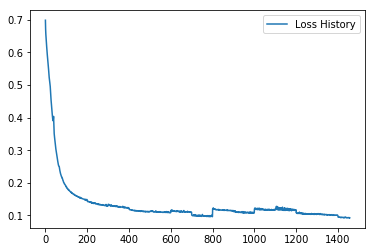

In [35]:
plt.plot(loss_hist, label="Loss History")
plt.legend()
plt.show
len(loss_hist)

In [36]:
# Music Generation
# input = initial note vector
# for t = 1:Tsong
#    input --> input kernel
#    run through 1 'call' of Model LSTM with present parameters / states
#    run through note-wise LSTM block as normally done to produce vector of generated samples
#    input = generated samples
#    music_sequence.append(input)

# store batch of music sequences in .MIDI files


#Load Model
restore_model_name = 'Practice_Dropout'

#Length of generated music
T_gen = 16*16
batch_gen_size = 5
keep_prob = 1

# start with initial Note_State_Batch with 't' dimension = 1 (can still a batch of samples run in parallel)
notes_gen_initial = np.zeros((batch_gen_size, num_notes, 1,2))

# Initial States
notes_gen = notes_gen_initial
    
timewise_state_val=[]
for i in range(len(num_t_units)):
    c = np.zeros((batch_gen_size*num_notes, num_t_units[i])) #start every batch with zero state in LSTM time cells
    h = np.zeros((batch_gen_size*num_notes, num_t_units[i]))
    timewise_state_val.append(LSTMStateTuple(h, c))
        
notewise_state_val=[]
for i in range(len(num_n_units)):
    c = np.zeros((batch_gen_size*1, num_n_units[i])) #start every batch with zero state in LSTM time cells
    h = np.zeros((batch_gen_size*1, num_n_units[i]))
    notewise_state_val.append(LSTMStateTuple(h, c))
        
notes_gen_arr=[]

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    
    print("Load the model from: {}".format(restore_model_name))
    saver.restore(sess, 'model/{}'.format(restore_model_name))
    

    for t in range(T_gen):
        feed_dict = {Note_State_Batch: notes_gen, timewise_state: timewise_state_val, notewise_state: notewise_state_val, time_init: t % 16, output_keep_prob: keep_prob}    
        timewise_state_val, notes_gen = np.squeeze(sess.run([timewise_state_out, note_gen_out], feed_dict = feed_dict), axis=2)
        #print('notes_gen shape = ', notes_gen.shape)
        #notes_gen = np.squeeze(notes_gen, axis=2)
        notes_gen_arr.append(np.squeeze(notes_gen))
        
        
        if t % 50 == 0:
            print('Timestep = ', t)
    
notes_gen_out = np.stack(notes_gen_arr, axis=2)
print(notes_gen_out.shape)
        


Load the model from: Practice_Dropout
INFO:tensorflow:Restoring parameters from model/Practice_Dropout
Timestep =  0
Timestep =  50
Timestep =  100
Timestep =  150
Timestep =  200
Timestep =  250
(5, 78, 256, 2)


In [37]:
# Save Generate Notes to .MIDI file

notes_gen_out = np.swapaxes(notes_gen_out, axis1=1, axis2=2)
print(notes_gen_out.shape)
#_, notes_gen_out = Utils.multi_training.getPieceBatch(training_pieces)


#print(test_batch.shape)
for iter in range(3):
    file = 'Generated_Midi_Files/PracticeDropout' + str(iter+3)
    midi_out = midi_musical_matrix.noteStateMatrixToMidi(notes_gen_out[iter,:,:,:], name=file)

(5, 256, 78, 2)


Items to Experiment with:
- different T length or variable length T from batch-to-batch for training
- categorize music, either through (unsupervised) clustering or (supervised) labeled music folders.  For clustering, the model would possibly find 'k' 'centroids' in an unsupervised manner each with its own music distribution, so during the music generation stage, 1 of these centroids would be selected for a piece of music.  
- use encoder to reduce dimensionality of each note vector (vector of 79 notes in 1 time step), similiar to encoding the words from the tweets in homework 3 (i.e. there are restricted combinations of notes that can be played simultaneously)
- more advanced sampling/exploring for training/music generation.  This may help prevent the algorithm from getting 'stuck' on a chord, or 